In [1]:
from sklearn.preprocessing import OrdinalEncoder
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, ExtraTreesClassifier
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression

In [2]:
df = pd.read_csv('train_data.csv')
df

,Sentence,Emotion
0,کی گفته مرد گریه نمیکنه!؟!؟ سیلم امشب سیل #اصفهان,SAD
1,عکسی که چند روز پیش گذاشته بودم این فیلم الانش...,OTHER
2,تنهاییم شبیه تنهاییه ظهرای بچگیم شده وقتی که ه...,SAD
3,خوبه تمام قسمت‌های گوشی رو محافظت می‌کنه,HAPPY
4,این خاک مال مردمان است نه حاکمان #ایران #مهسا_...,ANGRY
...,...,...
4919,من از بو و ماندگاریش راضی بودم ، قیمتش هم‌ مناسبه,HAPPY
4920,گاز نداریم آب نداریم برق نداریم نت نداریم پول ...,SAD
4921,یکی بهم گفت برنو چرا عاشق نمیشی گفتم ما پول عا...,SAD
4922,زیادی داریم به قضیه ی گاز میپردازیم فقط فراخوا...,OTHER


In [3]:
df.shape

(4924, 2)

In [4]:
df.describe()

,Sentence,Emotion
count,4924,4924
unique,4922,5
top,#NAME?,HAPPY
freq,3,1462


In [5]:
df.isnull().sum()

Sentence    0
Emotion     0
dtype: int64

In [6]:
df.duplicated().sum()

1

<AxesSubplot: >

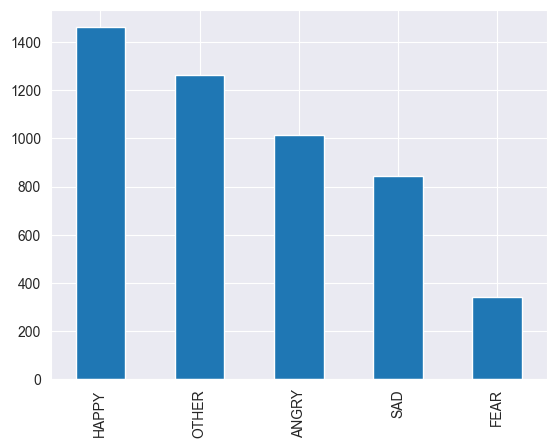

In [7]:
plot_df = df.Emotion.value_counts()
plot_df.plot(kind="bar")

# Preprocessing

At first we need to check the variety of the characters that is used in our data.

In [8]:
uniqueChars = set(''.join(df['Sentence']))
print(len(uniqueChars))
print(uniqueChars)

210
{'m', '\u200d', 'ᴇ', 'ّ', 'ص', 'b', '☺', 'ز', '⊰', 'ᴏ', 'ق', 'v', '&', '=', 'D', '7', 'ھ', 'ف', '☝', '❄', 'r', 'Q', 'l', '۲', '(', 'ژ', '٬', 'گ', '+', 'd', 'w', 'ا', '~', 'j', 'ث', 'a', '8', 'ع', 'ہ', 'أ', 'د', '¹', '۹', '5', 'J', '/', 'ی', 'h', 'ة', '4', 'ب', '’', 'f', 'k', 'ُ', '⭕', 'I', 'ي', '۸', '‐', 'W', '!', 'B', 'ٔ', '٠', '»', '۶', '٫', ']', '\u200c', 't', 'خ', '%', 'q', 'c', '✌', 'ل', '9', '⚘', 'R', 'ء', '٢', 'م', '°', 'ً', '♂', '♥', '2', 'آ', '-', ';', '6', '\u2067', 'N', '⛓', '‘', 'ە', '☠', 'K', '❤', '️', '\n', 'e', '٪', '،', '\u2066', 'U', 'ᴛ', 'ه', 'ى', 'ؤ', '|', '”', 'M', 'پ', ',', 'L', '۔', 'E', ':', 'ط', '[', 'y', 'ح', ')', 'و', '♀', '}', '_', '✍', '۷', 'p', 'ظ', '²', 'ِ', '…', 'ْ', '3', 'ʏ', '?', 'i', '*', 'A', 's', '\u2069', '.', '؛', '☹', '⃟', 'ش', 'S', 'َ', '٣', '✨', 'چ', 'س', '٦', '•', 'O', '⚽', 'ے', 'P', '✋', '⁉', 'H', 'ɴ', '۱', '0', '☄', 'ـ', '«', 'ئ', 'g', 'غ', 'ض', '1', '“', 'T', 'C', '#', 'ج', 'z', '^', 'ر', ' ', '۰', 'n', 'F', '⭐', '١', '؟', 'ټ', 'ك', '۳',

As we can see there is three important problem.
1. There is five type of 'ی' that can be a real problem because there is a unique unicode for each one.
2. There are persian and latin numbers together that can be a problem.
3. There are capital and small letter together.

So we have to handle these problem to clean our data and make that more usable and reliable.

In here we will define two function:
1. __normalize_persian__: This function will replace persian numbers with latin and handle five kind of 'ی' and make them one.
2. __preprocess_text__: This function will apply normalize_persian on our data and also make all of our latin letters lower case.

In [9]:
def normalize_persian(text):
    # Define a function to normalize Persian characters and numbers
    persian_digits = '۰۱۲۳۴۵۶۷۸۹٦'
    english_digits = '01234567896'
    yeh_characters = ['ی', 'ي', 'ے', 'ئ', 'ى']

    text = text.translate(str.maketrans(persian_digits, english_digits))
    for char in yeh_characters:
        text = text.replace(char, 'ی')

    return text

In [10]:
def preprocess_text(text):
    # Normalize Persian characters
    text = normalize_persian(text)

    # Convert to lowercase
    text = text.lower()

    # Add more preprocessing steps as needed

    return text

In [11]:
df['Sentence'] = df['Sentence'].apply(preprocess_text)
uniqueChars = set(''.join(df['Sentence']))
print(len(uniqueChars))
print(uniqueChars)

170
{'m', '\u200d', 'ᴇ', 'ّ', 'ص', 'b', '☺', 'ز', '⊰', 'ᴏ', 'ق', 'v', '&', '=', '7', 'ھ', 'ف', '☝', '❄', 'r', 'l', '(', 'ژ', '٬', 'گ', '+', 'd', 'w', 'ا', '~', 'j', 'ث', 'a', '8', 'ع', 'ہ', 'أ', 'د', '¹', '5', '/', 'ی', 'h', 'ة', '4', 'ب', '’', 'f', 'k', 'ُ', '⭕', '‐', '!', 'ٔ', '٠', '»', '٫', ']', '\u200c', 't', 'خ', '%', 'q', 'c', '✌', 'ل', '9', '⚘', 'ء', '٢', 'م', '°', 'ً', '♂', '♥', '2', 'آ', '-', ';', '6', '\u2067', '⛓', '‘', 'ە', '☠', '❤', '️', '\n', 'e', '٪', '،', '\u2066', 'ᴛ', 'ه', 'ؤ', '|', '”', 'پ', ',', '۔', ':', 'ط', '[', 'y', 'ح', ')', 'و', '♀', '}', '_', '✍', 'p', 'ظ', '²', 'ِ', '…', 'ْ', '3', 'ʏ', '?', 'i', '*', '\u2069', 's', '.', '؛', '☹', '⃟', 'ش', 'َ', '٣', '✨', 'چ', 'س', '•', '⚽', '✋', '⁉', 'ɴ', '0', '☄', 'ـ', '«', 'g', 'غ', 'ض', '1', '“', '#', 'ج', 'z', '^', 'ر', ' ', '⭐', 'n', '١', '؟', 'ټ', 'ك', 'o', 'x', '✅', '☘', 'ن', 'ۀ', 'ت', 'ذ', 'u', 'ک'}


In [12]:
import hazm
def text_normalizer(data):
    normalizer = hazm.Normalizer()
    data['Sentence'] = data['Sentence'].apply(normalizer.normalize)
    return data

def word_tokenizer(data):
    data['Sentence'] = data['Sentence'].apply(hazm.word_tokenize)
    return data

def text_lemmatizer(data):
    lemmatizer = hazm.Lemmatizer()
    data['Sentence'] = data['Sentence'].apply(lambda x: ' '.join([lemmatizer.lemmatize(word) for word in x]))
    return data

In [13]:
df = text_normalizer(df)
df = word_tokenizer(df)
df = text_lemmatizer(df)
df.head()

,Sentence,Emotion
0,کی گفته مرد گریه نمیکنه !؟!؟ سیل امشب سیل #اصفهان,SAD
1,عکس که چند روز پیش گذاشت#گذار این فیلم الانشه ...,OTHER
2,تن شبیه تنهاییه ظهرای بچگیم شده وقتی‌که همه می...,SAD
3,خوبه تمام قسمت گوشید#گوش رو محافظت می‌کنه,HAPPY
4,این خاک‌مال مردمان است نه حاکمان #ایران #مهسا_...,ANGRY


In [14]:
uniqueChars = set(''.join(df['Sentence']))
print(len(uniqueChars))
print(uniqueChars)

148
{'m', '\u200d', 'ᴇ', '⊰', 'ص', 'b', '☺', 'ز', 'ᴏ', 'ق', 'v', '&', '=', '☝', 'ف', '❄', 'r', 'l', '۲', '(', 'ژ', '٬', 'گ', '+', 'd', 'w', 'ا', '~', 'j', 'ث', '"', 'a', 'ع', 'أ', 'د', '¹', '۹', '/', 'ی', 'h', 'ة', 'ب', '’', 'f', 'k', '⭕', '۸', '‐', '!', '»', '۶', '٫', ']', '\u200c', 't', 'خ', 'q', 'c', '✌', 'ل', '⚘', 'ء', 'م', '°', '♂', '♥', 'آ', '-', ';', '\u2067', '⛓', '‘', '☠', '❤', '️', 'e', '٪', '،', '\u2066', 'ᴛ', 'ه', 'ؤ', '|', 'پ', ',', ':', 'ط', '[', 'y', 'ح', ')', 'و', '♀', '}', '_', '✍', '۷', 'p', 'ظ', '²', '…', 'ʏ', '?', 'i', '*', '\u2069', 's', '.', '؛', '☹', '⃟', 'ش', '✨', 'چ', 'س', '•', '⚽', '✋', '⁉', 'ɴ', '۱', '☄', '«', 'g', 'غ', 'ض', '#', 'ج', 'z', '^', 'ر', ' ', '۰', 'n', '⭐', '؟', '۳', 'o', 'x', '✅', '☘', 'ن', '۴', 'ت', 'ذ', '۵', 'u', 'ک'}


In [15]:
def containsEnglishLetters(word):
    for char in word:
        if char.isalpha() and char.isascii():
            return True
    return False

def removeEnglishWords(dataset):
    for i, element in enumerate(dataset):
        words = element.split()
        cleanedWords = []
        for word in words:
            if not containsEnglishLetters(word):
                cleanedWords.append(word)
        cleanedText = " ".join(cleanedWords)
        dataset[i] = cleanedText
    return dataset

In [16]:
df['Sentence'] = removeEnglishWords(df['Sentence'])

In [17]:
uniqueChars = set(''.join(df['Sentence']))
print(len(uniqueChars))
print(uniqueChars)

115
{'\u200d', '⊰', 'ص', '☺', 'ز', 'ق', '=', '☝', 'ف', '❄', '۲', '(', 'ژ', '٬', 'گ', '+', 'ا', '~', 'ث', '"', 'ع', 'أ', 'د', '۹', '/', 'ی', 'ة', 'ب', '’', '⭕', '۸', '‐', '!', '»', '۶', '٫', ']', '\u200c', 'خ', '✌', 'ل', '⚘', 'ء', 'م', '°', '♂', '♥', 'آ', '-', ';', '\u2067', '⛓', '‘', '☠', '❤', '️', '٪', '،', '\u2066', 'ه', 'ؤ', '|', 'پ', ',', ':', 'ط', '[', 'ح', ')', 'و', '♀', '}', '_', '✍', '۷', 'ظ', '²', '…', '?', '*', '\u2069', '.', '؛', '☹', '⃟', 'ش', '✨', 'چ', 'س', '•', '⚽', '✋', '⁉', '☄', '۱', '«', 'غ', 'ض', '#', 'ج', '^', 'ر', ' ', '۰', '⭐', '؟', '۳', '✅', '☘', 'ن', '۴', 'ت', 'ذ', '۵', 'ک'}


In [18]:
import pandas as pd
import re

def remove_emojis(text):
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

def clean_dataset(dataset):
    """
    Cleans a dataset by removing emojis from all text columns.

    Parameters:
    dataset (pandas.DataFrame): The input dataset to be cleaned.

    Returns:
    pandas.DataFrame: The cleaned dataset with emojis removed.
    """
    # Create a copy of the dataset to avoid modifying the original
    cleaned_dataset = dataset.copy()

    # Iterate through all text columns and remove emojis
    for column in dataset.select_dtypes(include=['object']):
        cleaned_dataset[column] = dataset[column].apply(remove_emojis)

    return cleaned_dataset

In [19]:
df = clean_dataset(df)
uniqueChars = set(''.join(df['Sentence']))
print(len(uniqueChars))
print(uniqueChars)

93
{'\u200d', '⊰', 'ص', 'ز', 'ق', '=', 'ف', '۲', '(', 'ژ', '٬', 'گ', '+', 'ا', '~', 'ث', '"', 'ع', 'أ', 'د', '۹', '/', 'ی', 'ة', 'ب', '’', '۸', '‐', '!', '»', '۶', '٫', ']', '\u200c', 'خ', 'ل', 'ء', 'م', '°', 'آ', '-', ';', '\u2067', '‘', '٪', '،', '\u2066', 'ه', 'ؤ', '|', 'پ', ',', ':', 'ط', '[', 'ح', ')', 'و', '}', '_', '۷', 'ظ', '²', '…', '?', '*', '\u2069', '.', '؛', '⃟', 'ش', 'چ', 'س', '•', '⁉', '۱', '«', 'غ', 'ض', '#', 'ج', '^', 'ر', ' ', '۰', '؟', '۳', 'ن', '۴', 'ت', 'ذ', '۵', 'ک'}


The next step in the preprocessing is to normalize the text using the Hazm library. Normalizing text in the context of natural language processing (NLP) refers to the process of transforming text into a standardized format or representation. This typically involves tasks such as converting all text to lowercase, removing stop words (common words that do not carry significant meaning), and other similar operations. After normalizing the text, we used a word tokenizer to separate the words into individual tokens. This is an important step for many NLP tasks, as it allows us to work with the text at the word level. The next step was lemmatization, which uses linguistic knowledge to convert words to their base or dictionary form. This helps to reduce the dimensionality of the text and can improve the performance of various NLP models. All above parts was doing these important steps.

In [20]:
from sklearn.model_selection import train_test_split
encoder = OrdinalEncoder()
df['emotion'] = encoder.fit_transform(df[['Emotion']])
train_data, test_data = train_test_split(df, random_state=42, test_size=0.2)

In [21]:
train_x = pd.DataFrame(train_data['Sentence'], columns=['Sentence'], index=train_data.index)
train_y = train_data['Emotion']

test_x = pd.DataFrame(test_data['Sentence'], columns=['Sentence'], index=test_data.index)
test_y = test_data['Emotion']

As it is clear, it is impossible to train a machine learning model on data that consists solely of text and words. This is because models require numerical inputs that they can interpret and process, rather than raw text data. Therefore, we need to convert the textual data into numerical representations that the model can understand.
One common technique for this is called TF-IDF (Term Frequency-Inverse Document Frequency). TF-IDF is a method that assigns a numerical value to each word in a text corpus, based on the word's frequency within a document and across the entire corpus.


Sure, here's the TF-IDF (Term Frequency-Inverse Document Frequency) formulation in Markdown format:

$$
\text{TF-IDF}(t, d) = \text{TF}(t, d) \times \text{IDF}(t)
$$

where:

$$
\text{TF}(t, d) = \frac{\text{Number of times term } t \text{ appears in document } d}{\text{Total number of terms in document } d}
$$

and

$$
\text{IDF}(t) = \log\left(\frac{\text{Total number of documents}}{\text{Number of documents with term } t \text{ in it}}\right)
$$

In [22]:
vectorizer = TfidfVectorizer()
vector = vectorizer.fit_transform(train_x['Sentence'])
vectorized_x_train = pd.DataFrame(vector.toarray(), columns=vectorizer.get_feature_names_out(), index=train_data.index)

vector2 = vectorizer.transform(test_x['Sentence'])
vectorized_x_test = pd.DataFrame(vector2.toarray(), columns=vectorizer.get_feature_names_out(), index=test_data.index)
print(vectorized_x_train.shape)
print(vectorized_x_test.shape)

(3939, 7559)
(985, 7559)


In [23]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

# Oversampling using SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(vectorized_x_train, train_y)

# Undersampling using Random Undersampler
rus = RandomUnderSampler(random_state=42)
X_train_resampled, y_train_resampled = rus.fit_resample(X_train_resampled, y_train_resampled)

# Model Training

In this section we will try to find the best parameters for each model and also try to find the best model by using cross validation.

For this object, for each model we will define a param_grids that is our parameter that we want to find the optimum between them.
After that by using CV we will find the best parameters.
Then we will train a model and estimate the error by CV.

In here we will define a function that by using train and test set and model and parameters for grid search, it will give us the best parameters by CV and also evaluate the performance of the by CV and also by test set and show us confusion matrix too.

In [24]:
from sklearn.metrics import f1_score, precision_score, accuracy_score, roc_curve, ConfusionMatrixDisplay, confusion_matrix, auc
from sklearn.model_selection import GridSearchCV, StratifiedKFold
import matplotlib.pyplot as plt

def model_train_test_evaluating(x_train, y_train, x_test, y_test, model, param_grid):
    grid_search = GridSearchCV(model, param_grid=param_grid, cv=5, scoring='f1_macro')
    grid_search.fit(x_train, y_train)
    classifier = grid_search.best_estimator_

    y_train_pred = classifier.predict(x_train)
    y_test_pred = classifier.predict(x_test)

    train_accuracy = accuracy_score(y_train, y_train_pred)
    f1_train = f1_score(y_train, y_train_pred, average='macro')
    if not y_test.isnull().all():
        test_accuracy = accuracy_score(y_test, y_test_pred)
        f1_test = f1_score(y_test, y_test_pred, average='macro')

    print('Cross validation scores:')
    print(f"Best parameters: {grid_search.best_params_}")
    print(f"Best score: {grid_search.best_score_:.4f}")

    print('train_data report:')
    print('Acuuracy: ', end='')
    print(train_accuracy)
    print('F1_score: ', end='')
    print(f1_train)

    cm = confusion_matrix(y_train, y_train_pred)
    # Plot the confusion matrix
    plt.figure(figsize=(8, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()

    if not y_test.isnull().all():
        print('test_data report:')
        print('Acuuracy: ', end='')
        print(test_accuracy)
        print('F1_score: ', end='')
        print(f1_test)

        cm = confusion_matrix(y_test, y_test_pred)
        # Plot the confusion matrix
        plt.figure(figsize=(8, 6))
        disp = ConfusionMatrixDisplay(confusion_matrix=cm)
        disp.plot()
        plt.title('Confusion Matrix')
        plt.xlabel('Predicted Labels')
        plt.ylabel('True Labels')
        plt.show()

    return y_test_pred

### Decision Tree
First of all we will work with Decision tree and for that we will check criterion and max depth.

In [25]:
param_grids = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [5, 10, 15, None],
}

Cross validation scores:
Best parameters: {'criterion': 'gini', 'max_depth': None}
Best score: 0.6310
train_data report:
Acuuracy: 0.998768689533861
F1_score: 0.9987689208460125


<Figure size 800x600 with 0 Axes>

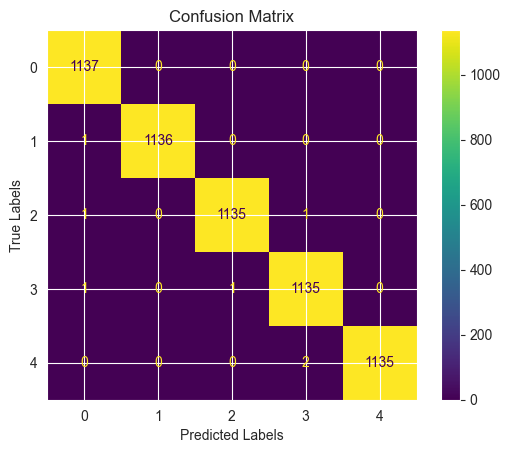

test_data report:
Acuuracy: 0.49137055837563454
F1_score: 0.46576800080584774


<Figure size 800x600 with 0 Axes>

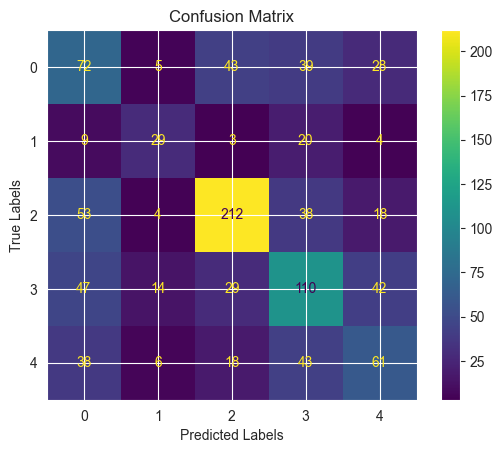

array(['ANGRY', 'ANGRY', 'HAPPY', 'ANGRY', 'FEAR', 'OTHER', 'HAPPY',
       'HAPPY', 'HAPPY', 'OTHER', 'HAPPY', 'HAPPY', 'SAD', 'OTHER',
       'HAPPY', 'ANGRY', 'SAD', 'SAD', 'OTHER', 'OTHER', 'SAD', 'SAD',
       'HAPPY', 'SAD', 'ANGRY', 'HAPPY', 'OTHER', 'ANGRY', 'OTHER',
       'HAPPY', 'OTHER', 'ANGRY', 'HAPPY', 'ANGRY', 'SAD', 'OTHER',
       'HAPPY', 'HAPPY', 'SAD', 'HAPPY', 'SAD', 'ANGRY', 'ANGRY', 'SAD',
       'HAPPY', 'ANGRY', 'HAPPY', 'ANGRY', 'OTHER', 'HAPPY', 'OTHER',
       'HAPPY', 'FEAR', 'OTHER', 'OTHER', 'OTHER', 'HAPPY', 'HAPPY',
       'ANGRY', 'ANGRY', 'FEAR', 'FEAR', 'ANGRY', 'SAD', 'OTHER', 'OTHER',
       'HAPPY', 'HAPPY', 'ANGRY', 'OTHER', 'ANGRY', 'HAPPY', 'ANGRY',
       'ANGRY', 'SAD', 'SAD', 'ANGRY', 'HAPPY', 'SAD', 'OTHER', 'OTHER',
       'OTHER', 'OTHER', 'HAPPY', 'ANGRY', 'OTHER', 'OTHER', 'HAPPY',
       'SAD', 'FEAR', 'OTHER', 'HAPPY', 'SAD', 'HAPPY', 'ANGRY', 'OTHER',
       'HAPPY', 'ANGRY', 'ANGRY', 'HAPPY', 'ANGRY', 'OTHER', 'HAPPY',
       'SAD'

In [26]:
model_train_test_evaluating(X_train_resampled, y_train_resampled, vectorized_x_test, test_y, DecisionTreeClassifier(), param_grids)

### Random Forest
We will continue with random forest model and we will check number of estimators and max depth for that.

In [27]:
param_grids = {
    'n_estimators': [50, 100, 150],
    'max_depth': [5, 10, 15, None],
}

Cross validation scores:
Best parameters: {'max_depth': None, 'n_estimators': 100}
Best score: 0.7446
train_data report:
Acuuracy: 0.998768689533861
F1_score: 0.9987683017457843


<Figure size 800x600 with 0 Axes>

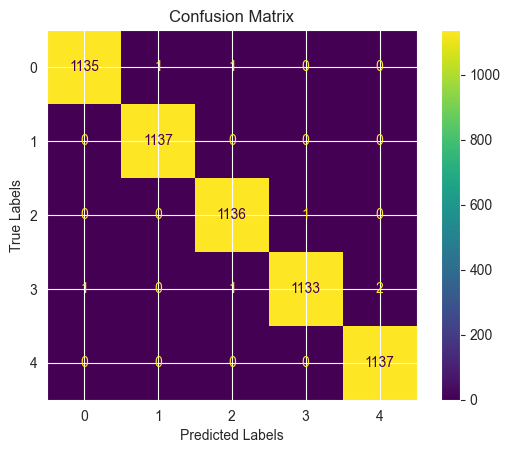

test_data report:
Acuuracy: 0.5725888324873096
F1_score: 0.5379783450356301


<Figure size 800x600 with 0 Axes>

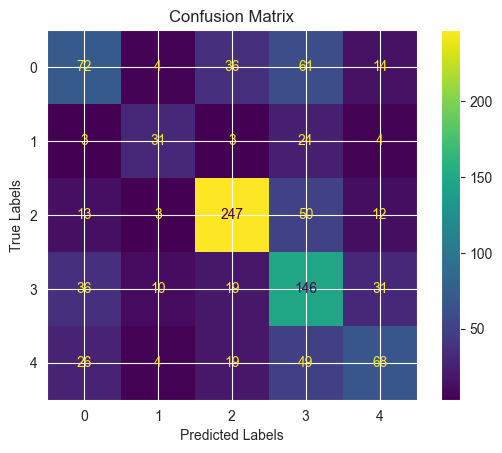

array(['OTHER', 'ANGRY', 'HAPPY', 'SAD', 'FEAR', 'OTHER', 'HAPPY',
       'HAPPY', 'OTHER', 'OTHER', 'HAPPY', 'HAPPY', 'SAD', 'OTHER',
       'HAPPY', 'OTHER', 'SAD', 'SAD', 'SAD', 'OTHER', 'FEAR', 'SAD',
       'HAPPY', 'HAPPY', 'ANGRY', 'HAPPY', 'OTHER', 'HAPPY', 'SAD',
       'OTHER', 'OTHER', 'ANGRY', 'HAPPY', 'OTHER', 'SAD', 'OTHER',
       'ANGRY', 'HAPPY', 'SAD', 'HAPPY', 'HAPPY', 'ANGRY', 'ANGRY',
       'ANGRY', 'HAPPY', 'ANGRY', 'HAPPY', 'ANGRY', 'OTHER', 'HAPPY',
       'OTHER', 'HAPPY', 'SAD', 'OTHER', 'OTHER', 'OTHER', 'HAPPY',
       'ANGRY', 'ANGRY', 'ANGRY', 'OTHER', 'FEAR', 'ANGRY', 'OTHER',
       'ANGRY', 'FEAR', 'SAD', 'HAPPY', 'OTHER', 'ANGRY', 'ANGRY',
       'HAPPY', 'HAPPY', 'SAD', 'HAPPY', 'OTHER', 'OTHER', 'HAPPY', 'SAD',
       'OTHER', 'OTHER', 'OTHER', 'SAD', 'HAPPY', 'ANGRY', 'OTHER',
       'OTHER', 'HAPPY', 'SAD', 'FEAR', 'OTHER', 'OTHER', 'ANGRY',
       'HAPPY', 'OTHER', 'SAD', 'SAD', 'OTHER', 'ANGRY', 'HAPPY', 'OTHER',
       'OTHER', 'HAPPY', 'SAD', 

In [28]:
model_train_test_evaluating(X_train_resampled, y_train_resampled, vectorized_x_test, test_y, RandomForestClassifier(), param_grids)

### Extra Trees
Next two cell will check number of estimators and criterion for extra trees model.

In [29]:
param_grids = {
    'n_estimators': [50, 100, 150],
    'criterion': ['gini', 'entropy'],
}

Cross validation scores:
Best parameters: {'criterion': 'entropy', 'n_estimators': 150}
Best score: 0.7782
train_data report:
Acuuracy: 0.998768689533861
F1_score: 0.9987689208460125


<Figure size 800x600 with 0 Axes>

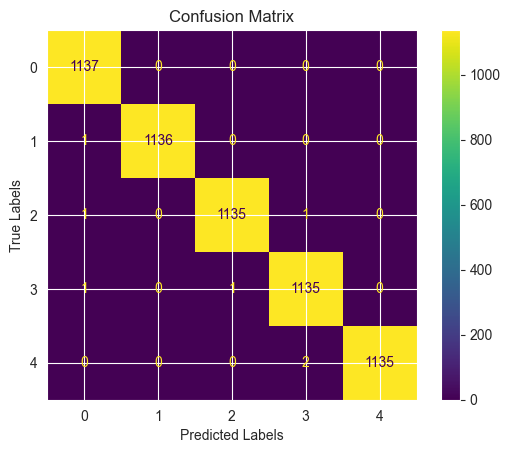

test_data report:
Acuuracy: 0.5969543147208122
F1_score: 0.5664693252591674


<Figure size 800x600 with 0 Axes>

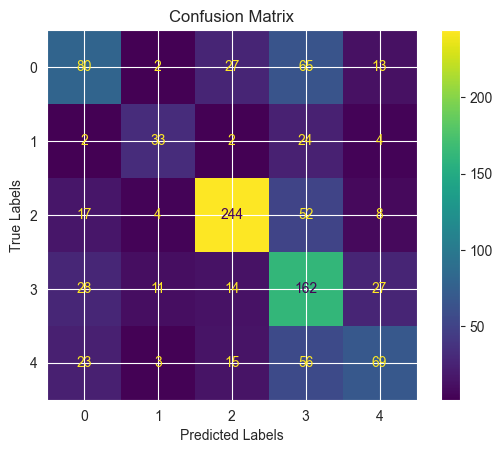

array(['OTHER', 'ANGRY', 'HAPPY', 'OTHER', 'FEAR', 'OTHER', 'HAPPY',
       'HAPPY', 'OTHER', 'OTHER', 'HAPPY', 'HAPPY', 'SAD', 'OTHER',
       'HAPPY', 'OTHER', 'SAD', 'SAD', 'OTHER', 'OTHER', 'FEAR', 'SAD',
       'HAPPY', 'HAPPY', 'ANGRY', 'HAPPY', 'OTHER', 'HAPPY', 'SAD',
       'OTHER', 'OTHER', 'ANGRY', 'HAPPY', 'ANGRY', 'ANGRY', 'ANGRY',
       'HAPPY', 'HAPPY', 'SAD', 'HAPPY', 'HAPPY', 'ANGRY', 'ANGRY', 'SAD',
       'HAPPY', 'ANGRY', 'HAPPY', 'ANGRY', 'OTHER', 'HAPPY', 'OTHER',
       'HAPPY', 'OTHER', 'OTHER', 'OTHER', 'OTHER', 'HAPPY', 'ANGRY',
       'ANGRY', 'ANGRY', 'OTHER', 'FEAR', 'OTHER', 'OTHER', 'OTHER',
       'FEAR', 'SAD', 'HAPPY', 'OTHER', 'ANGRY', 'ANGRY', 'HAPPY',
       'HAPPY', 'SAD', 'OTHER', 'OTHER', 'HAPPY', 'HAPPY', 'SAD', 'OTHER',
       'OTHER', 'OTHER', 'SAD', 'HAPPY', 'ANGRY', 'OTHER', 'OTHER',
       'HAPPY', 'SAD', 'FEAR', 'HAPPY', 'OTHER', 'ANGRY', 'HAPPY',
       'OTHER', 'HAPPY', 'SAD', 'OTHER', 'ANGRY', 'HAPPY', 'OTHER',
       'OTHER', 'HAPPY',

In [30]:
model_train_test_evaluating(X_train_resampled, y_train_resampled, vectorized_x_test, test_y, ExtraTreesClassifier(), param_grids)

### Light GBM
This part is for Light GBM model and number of  leaves and learning rate will be checked.

In [31]:
param_grids = {
    'num_leaves': [31, 63, 127],
    'learning_rate': [0.1, 0.2, 0.3]
}

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005179 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 14234
[LightGBM] [Info] Number of data points in the train set: 4548, number of used features: 513
[LightGBM] [Info] Start training from score -1.610098
[LightGBM] [Info] Start training from score -1.608998
[LightGBM] [Info] Start training from score -1.610098
[LightGBM] [Info] Start training from score -1.608998
[LightGBM] [Info] Start training from score -1.608998
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003458 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 14320
[LightGBM] [Info] Number of data points in the train set: 4548, number of used features: 523
[LightGBM] [Info] Star

<Figure size 800x600 with 0 Axes>

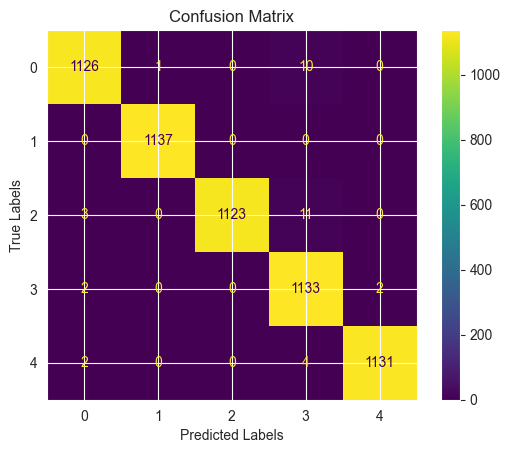

test_data report:
Acuuracy: 0.5979695431472081
F1_score: 0.5665245492791797


<Figure size 800x600 with 0 Axes>

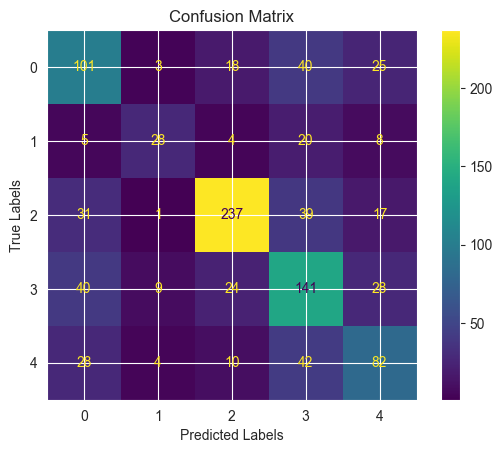

array(['OTHER', 'ANGRY', 'ANGRY', 'ANGRY', 'FEAR', 'OTHER', 'HAPPY',
       'OTHER', 'ANGRY', 'ANGRY', 'HAPPY', 'HAPPY', 'SAD', 'ANGRY',
       'HAPPY', 'OTHER', 'ANGRY', 'HAPPY', 'OTHER', 'OTHER', 'FEAR',
       'SAD', 'HAPPY', 'ANGRY', 'ANGRY', 'HAPPY', 'OTHER', 'HAPPY',
       'OTHER', 'SAD', 'OTHER', 'ANGRY', 'HAPPY', 'OTHER', 'ANGRY',
       'ANGRY', 'ANGRY', 'HAPPY', 'SAD', 'HAPPY', 'HAPPY', 'ANGRY',
       'ANGRY', 'SAD', 'HAPPY', 'ANGRY', 'HAPPY', 'ANGRY', 'OTHER',
       'ANGRY', 'OTHER', 'HAPPY', 'SAD', 'OTHER', 'ANGRY', 'ANGRY',
       'HAPPY', 'ANGRY', 'ANGRY', 'ANGRY', 'OTHER', 'FEAR', 'SAD',
       'ANGRY', 'OTHER', 'OTHER', 'SAD', 'HAPPY', 'OTHER', 'ANGRY',
       'ANGRY', 'HAPPY', 'HAPPY', 'SAD', 'HAPPY', 'ANGRY', 'SAD', 'HAPPY',
       'SAD', 'HAPPY', 'OTHER', 'FEAR', 'SAD', 'HAPPY', 'ANGRY', 'OTHER',
       'OTHER', 'HAPPY', 'SAD', 'FEAR', 'OTHER', 'OTHER', 'ANGRY', 'SAD',
       'OTHER', 'HAPPY', 'SAD', 'ANGRY', 'SAD', 'HAPPY', 'ANGRY', 'ANGRY',
       'HAPPY', 'SAD'

In [32]:
model_train_test_evaluating(X_train_resampled, y_train_resampled, vectorized_x_test, test_y, LGBMClassifier(), param_grids)

### XGBoost
This time its XGBoost turn to be checked.

In [37]:
param_grids = {
    'max_depth': [5, 10, 15], 'learning_rate': [0.1, 0.2, 0.3]
}
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Assume you have your training and test data loaded into variables X_train and X_test

# Standardize the training and test data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_resampled)
X_test_scaled = scaler.transform(vectorized_x_test)

num_components = 30

# Reduce the dimensionality of the training and test data
pca = PCA(n_components=num_components)
X_train_reduced = pca.fit_transform(X_train_scaled)
X_test_reduced = pca.transform(X_test_scaled)

In [38]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
train_y_encoded = label_encoder.fit_transform(train_y)
test_y_encoded = label_encoder.transform(test_y)
model_train_test_evaluating(X_train_reduced, y_train_resampled, X_test_reduced, test_y_encoded, XGBClassifier(), param_grids)

ValueError: 
All the 45 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
45 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Lenovo\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Lenovo\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py", line 620, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "C:\Users\Lenovo\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\sklearn.py", line 1440, in fit
    raise ValueError(
ValueError: Invalid classes inferred from unique values of `y`.  Expected: [0 1 2 3 4], got ['ANGRY' 'FEAR' 'HAPPY' 'OTHER' 'SAD']


### Logistic Regression
Our work with tree based models is done. Now we will work with other classic models.
First of all we will start with logistic regression.

In [39]:
param_grids={
    'penalty': ['l1', 'l2'],
}

C:\Users\Lenovo\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
5 fits failed out of a total of 10.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Lenovo\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Lenovo\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Lenovo\AppD

Cross validation scores:
Best parameters: {'penalty': 'l2'}
Best score: 0.7486
train_data report:
Acuuracy: 0.9083553210202286
F1_score: 0.9083529427094168


<Figure size 800x600 with 0 Axes>

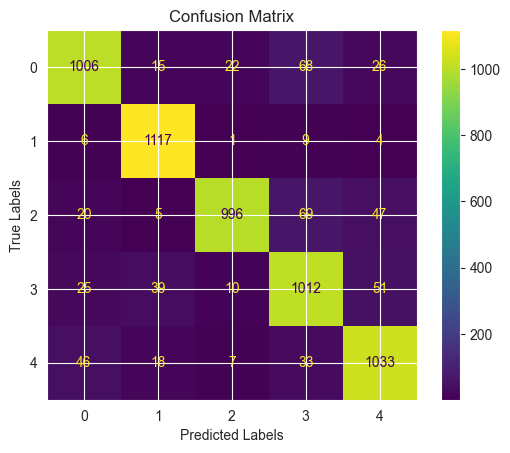

test_data report:
Acuuracy: 0.6203045685279188
F1_score: 0.5959236084851032


<Figure size 800x600 with 0 Axes>

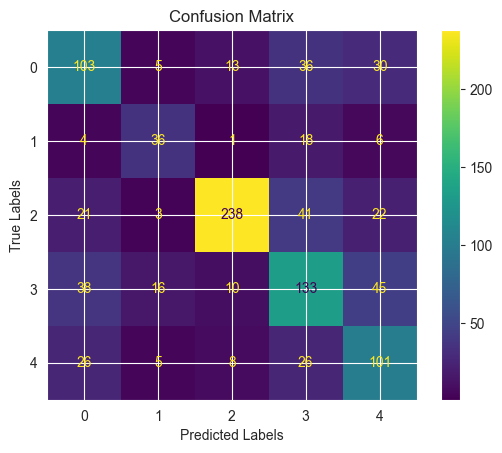

array(['OTHER', 'ANGRY', 'ANGRY', 'OTHER', 'FEAR', 'OTHER', 'HAPPY',
       'ANGRY', 'OTHER', 'OTHER', 'HAPPY', 'HAPPY', 'SAD', 'ANGRY',
       'HAPPY', 'OTHER', 'OTHER', 'ANGRY', 'ANGRY', 'FEAR', 'FEAR', 'SAD',
       'HAPPY', 'HAPPY', 'ANGRY', 'HAPPY', 'ANGRY', 'HAPPY', 'SAD',
       'OTHER', 'OTHER', 'ANGRY', 'HAPPY', 'ANGRY', 'SAD', 'OTHER',
       'ANGRY', 'HAPPY', 'SAD', 'HAPPY', 'HAPPY', 'SAD', 'ANGRY', 'SAD',
       'HAPPY', 'ANGRY', 'HAPPY', 'ANGRY', 'OTHER', 'HAPPY', 'OTHER',
       'HAPPY', 'SAD', 'OTHER', 'OTHER', 'OTHER', 'HAPPY', 'ANGRY',
       'ANGRY', 'ANGRY', 'OTHER', 'FEAR', 'OTHER', 'ANGRY', 'OTHER',
       'FEAR', 'SAD', 'HAPPY', 'OTHER', 'ANGRY', 'ANGRY', 'HAPPY',
       'HAPPY', 'SAD', 'HAPPY', 'ANGRY', 'HAPPY', 'HAPPY', 'SAD', 'SAD',
       'OTHER', 'FEAR', 'SAD', 'HAPPY', 'ANGRY', 'OTHER', 'OTHER',
       'HAPPY', 'SAD', 'FEAR', 'OTHER', 'SAD', 'ANGRY', 'ANGRY', 'SAD',
       'HAPPY', 'SAD', 'SAD', 'SAD', 'HAPPY', 'OTHER', 'HAPPY', 'HAPPY',
       'SAD', 'OTHER

In [40]:
model_train_test_evaluating(X_train_resampled, y_train_resampled, vectorized_x_test, test_y, LogisticRegression(), param_grids)

### KNN
After LR we will check the KNN.

In [41]:
param_grids = {
        'algorithm': ['auto', 'brute'],
}

Cross validation scores:
Best parameters: {'algorithm': 'auto'}
Best score: 0.3745
train_data report:
Acuuracy: 0.5408970976253298
F1_score: 0.5075739517870315


<Figure size 800x600 with 0 Axes>

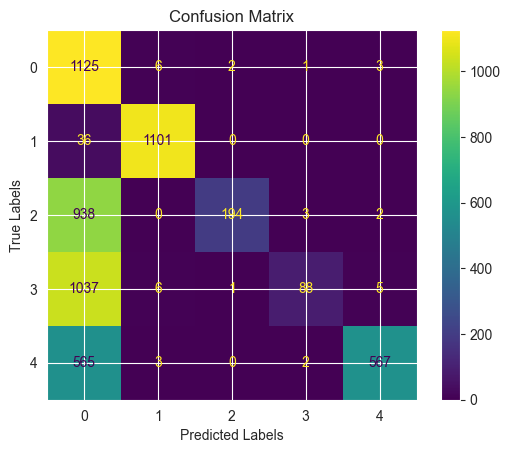

test_data report:
Acuuracy: 0.24060913705583756
F1_score: 0.16656604122321889


<Figure size 800x600 with 0 Axes>

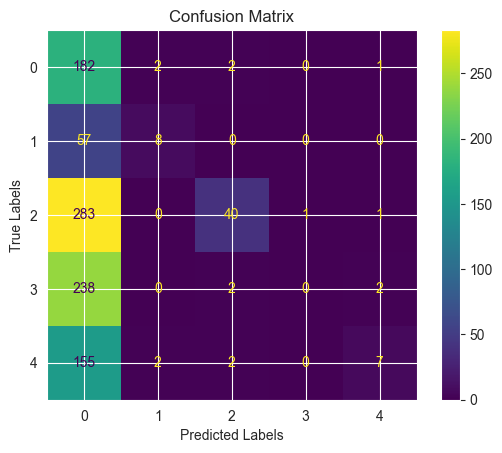

array(['ANGRY', 'ANGRY', 'ANGRY', 'ANGRY', 'ANGRY', 'ANGRY', 'HAPPY',
       'ANGRY', 'ANGRY', 'ANGRY', 'HAPPY', 'ANGRY', 'ANGRY', 'ANGRY',
       'ANGRY', 'ANGRY', 'ANGRY', 'ANGRY', 'ANGRY', 'ANGRY', 'FEAR',
       'ANGRY', 'ANGRY', 'ANGRY', 'ANGRY', 'ANGRY', 'ANGRY', 'ANGRY',
       'ANGRY', 'ANGRY', 'ANGRY', 'ANGRY', 'ANGRY', 'ANGRY', 'ANGRY',
       'ANGRY', 'ANGRY', 'ANGRY', 'ANGRY', 'HAPPY', 'ANGRY', 'ANGRY',
       'ANGRY', 'ANGRY', 'ANGRY', 'ANGRY', 'ANGRY', 'ANGRY', 'ANGRY',
       'ANGRY', 'ANGRY', 'ANGRY', 'ANGRY', 'ANGRY', 'ANGRY', 'ANGRY',
       'ANGRY', 'ANGRY', 'ANGRY', 'ANGRY', 'ANGRY', 'ANGRY', 'ANGRY',
       'ANGRY', 'ANGRY', 'ANGRY', 'ANGRY', 'HAPPY', 'ANGRY', 'ANGRY',
       'ANGRY', 'ANGRY', 'ANGRY', 'ANGRY', 'ANGRY', 'ANGRY', 'ANGRY',
       'HAPPY', 'ANGRY', 'ANGRY', 'ANGRY', 'ANGRY', 'ANGRY', 'ANGRY',
       'ANGRY', 'ANGRY', 'ANGRY', 'ANGRY', 'ANGRY', 'ANGRY', 'ANGRY',
       'ANGRY', 'ANGRY', 'ANGRY', 'ANGRY', 'ANGRY', 'ANGRY', 'ANGRY',
       'ANGRY', 'ANGR

In [43]:
from sklearn.neighbors import KNeighborsClassifier

model_train_test_evaluating(X_train_resampled, y_train_resampled, vectorized_x_test, test_y, KNeighborsClassifier(), param_grids)

### SVC
And we will check the support vector classifier as the last model.

In [46]:
param_grids = {
    'kernel': ['rbf', 'poly'],
}

Cross validation scores:
Best parameters: {'kernel': 'rbf'}
Best score: 0.7912
train_data report:
Acuuracy: 0.9910290237467019
F1_score: 0.9910314264001929


<Figure size 800x600 with 0 Axes>

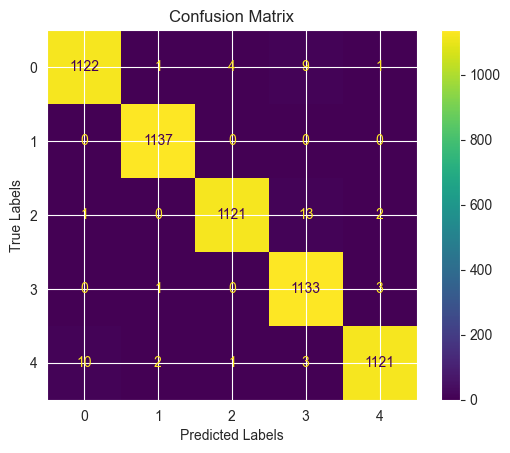

test_data report:
Acuuracy: 0.6243654822335025
F1_score: 0.5864721497137091


<Figure size 800x600 with 0 Axes>

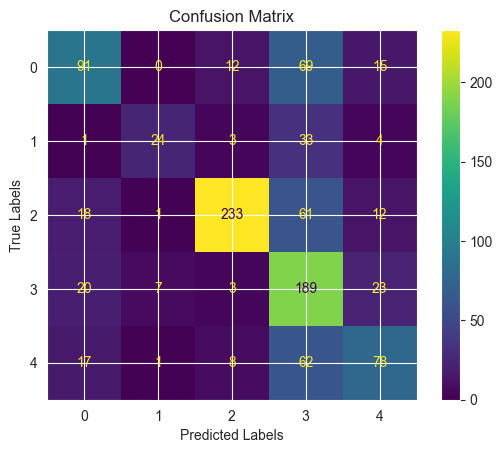

array(['OTHER', 'OTHER', 'ANGRY', 'OTHER', 'OTHER', 'OTHER', 'HAPPY',
       'ANGRY', 'OTHER', 'OTHER', 'HAPPY', 'HAPPY', 'SAD', 'ANGRY',
       'HAPPY', 'OTHER', 'OTHER', 'SAD', 'OTHER', 'OTHER', 'FEAR', 'SAD',
       'HAPPY', 'OTHER', 'ANGRY', 'HAPPY', 'OTHER', 'HAPPY', 'SAD',
       'OTHER', 'OTHER', 'ANGRY', 'HAPPY', 'ANGRY', 'SAD', 'OTHER',
       'ANGRY', 'HAPPY', 'OTHER', 'HAPPY', 'HAPPY', 'ANGRY', 'ANGRY',
       'ANGRY', 'HAPPY', 'ANGRY', 'HAPPY', 'ANGRY', 'OTHER', 'HAPPY',
       'OTHER', 'HAPPY', 'OTHER', 'OTHER', 'OTHER', 'OTHER', 'HAPPY',
       'ANGRY', 'ANGRY', 'ANGRY', 'OTHER', 'OTHER', 'OTHER', 'OTHER',
       'OTHER', 'FEAR', 'SAD', 'HAPPY', 'OTHER', 'OTHER', 'ANGRY',
       'HAPPY', 'HAPPY', 'SAD', 'HAPPY', 'OTHER', 'HAPPY', 'HAPPY', 'SAD',
       'OTHER', 'OTHER', 'OTHER', 'SAD', 'HAPPY', 'ANGRY', 'OTHER',
       'OTHER', 'HAPPY', 'SAD', 'OTHER', 'OTHER', 'OTHER', 'ANGRY',
       'ANGRY', 'OTHER', 'HAPPY', 'OTHER', 'SAD', 'SAD', 'HAPPY', 'OTHER',
       'OTHER', 'HA

In [47]:
from sklearn.svm import SVC

model_train_test_evaluating(X_train_resampled, y_train_resampled, vectorized_x_test, test_y, SVC(), param_grids)

The models which we trained include some tree-based models such as DecisionTreeClassifier, RandomForestClassifier, and XGBoost. We also trained Support Vector Machines (SVM) and Logistic Regression. It is obvious that the non-tree based models, such as SVM and Logistic Regression, have performed significantly better than the tree-based models. Among the tree-based models, the ensemble learning models, like RandomForest and XGBoost, have had better results compared to the single DecisionTreeClassifier model. Ensemble methods, such as Random Forest and XGBoost, combine multiple decision trees to create a more robust and accurate model, which helps to overcome the limitations of individual decision trees and improves the overall performance. The superior performance of the non-tree based models, such as SVM and Logistic Regression, suggests that the underlying data and problem at hand may be better suited for these types of algorithms compared to the tree-based models.

# Pipeline
In this part we will create a pipeline that by giving train test model and parameters, the pipeline will vectorize the data, normalize that and also by using CV find the pest parameters and evaluate the CV score and also evaluate the performance on test data.

In [48]:
def column_name_set(data):
    num_cols = data.shape[1]

    if num_cols == 2:
        data.columns = ['Sentence', 'Emotion']
    else:
        data.columns = ['Sentence']
        data['Emotion'] = None

    return data

Next two functions transform the persian numbers to latin and normalize five kind of 'ی' and give us just one kind. Also make all of english letters in lower case.

In [49]:
def normalize_persian(text):
    # Define a function to normalize Persian characters and numbers
    persian_digits = '۰۱۲۳۴۵۶۷۸۹٦'
    english_digits = '01234567896'
    yeh_characters = ['ی', 'ي', 'ے', 'ئ', 'ى']

    text = text.translate(str.maketrans(persian_digits, english_digits))
    for char in yeh_characters:
        text = text.replace(char, 'ی')

    return text

In [50]:
def preprocess_text(text):
    # Normalize Persian characters
    text = normalize_persian(text)

    # Convert to lowercase
    text = text.lower()

    # Add more preprocessing steps as needed

    return text

Next function split the data to features and target set.

In [51]:
def target_split(train_data, test_data):
    train_x = pd.DataFrame(train_data['Sentence'], columns=['Sentence'], index=train_data.index)
    train_y = train_data['Emotion']

    test_x = pd.DataFrame(test_data['Sentence'], columns=['Sentence'], index=test_data.index)
    test_y = test_data['Emotion']

    return train_x, train_y, test_x, test_y

By using next function we can vectorize our data.

In [52]:
from sklearn.feature_extraction.text import TfidfVectorizer

def text_vectorizer(train_x, test_x):

    vectorizer = TfidfVectorizer()
    vector = vectorizer.fit_transform(train_x['Sentence'])
    vectorized_x_train = pd.DataFrame(vector.toarray(), columns=vectorizer.get_feature_names_out(), index=train_x.index)

    vector2 = vectorizer.transform(test_x['Sentence'])
    vectorized_x_test = pd.DataFrame(vector2.toarray(), columns=vectorizer.get_feature_names_out(), index=test_x.index)

    return vectorized_x_train, vectorized_x_test

In here we will define a function that by using train and test set and model and parameters for grid search, it will give us the best parameters by CV and also evaluate the performance of the by CV and also by test set and show us confusion matrix too.

In [53]:
from sklearn.metrics import f1_score, precision_score, accuracy_score, roc_curve, ConfusionMatrixDisplay, confusion_matrix, auc
from sklearn.model_selection import GridSearchCV, StratifiedKFold
import matplotlib.pyplot as plt

def model_train_test_evaluating(x_train, y_train, x_test, y_test, model, param_grid):
    grid_search = GridSearchCV(model, param_grid=param_grid, cv=5, scoring='f1_macro')
    grid_search.fit(x_train, y_train)
    classifier = grid_search.best_estimator_

    y_train_pred = classifier.predict(x_train)
    y_test_pred = classifier.predict(x_test)

    train_accuracy = accuracy_score(y_train, y_train_pred)
    f1_train = f1_score(y_train, y_train_pred, average='macro')
    if not y_test.isnull().all():
        test_accuracy = accuracy_score(y_test, y_test_pred)
        f1_test = f1_score(y_test, y_test_pred, average='macro')

    print('Cross validation scores:')
    print(f"Best parameters: {grid_search.best_params_}")
    print(f"Best score: {grid_search.best_score_:.4f}")

    print('train_data report:')
    print('Acuuracy: ', end='')
    print(train_accuracy)
    print('F1_score: ', end='')
    print(f1_train)

    cm = confusion_matrix(y_train, y_train_pred)
    # Plot the confusion matrix
    plt.figure(figsize=(8, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()

    if not y_test.isnull().all():
        print('test_data report:')
        print('Acuuracy: ', end='')
        print(test_accuracy)
        print('F1_score: ', end='')
        print(f1_test)

        cm = confusion_matrix(y_test, y_test_pred)
        # Plot the confusion matrix
        plt.figure(figsize=(8, 6))
        disp = ConfusionMatrixDisplay(confusion_matrix=cm)
        disp.plot()
        plt.title('Confusion Matrix')
        plt.xlabel('Predicted Labels')
        plt.ylabel('True Labels')
        plt.show()

    return y_test_pred

And at last it is our pipe line that ease our work.

In [54]:
from sklearn.preprocessing import LabelEncoder

def pipline(train, test, model, param_grid):
    # Preproccessing

    # column name setting
    train = column_name_set(train)
    test = column_name_set(test)

    # changing ی in the text
    train['Sentence'] = train['Sentence'].apply(preprocess_text)
    test['Sentence'] = test['Sentence'].apply(preprocess_text)

    # normalize and tokenize the text
    train = text_normalizer(train)
    train = word_tokenizer(train)
    test = text_normalizer(test)
    test = word_tokenizer(test)

    # lemmatizing the text
    train = text_lemmatizer(train)
    test = text_lemmatizer(test)

    # target splitting
    train_x, train_y, test_x, test_y = target_split(train, test)

    # text vectorizing
    vectorized_x_train, vectorized_x_test = text_vectorizer(train_x, test_x)

    #encoding target
    label_encoder = LabelEncoder()
    train_y_encoded = label_encoder.fit_transform(train_y)
    if not test_y.isnull().all():
        test_y_encoded = pd.Series(label_encoder.transform(test_y))
    else:
        test_y_encoded = pd.Series(test_y)

    # Model training
    y_pred = model_train_test_evaluating(vectorized_x_train, train_y_encoded, vectorized_x_test, test_y_encoded, model, param_grid)
    y_pred = label_encoder.inverse_transform(y_pred)

    return y_pred

In [55]:
tr_data = pd.read_csv('train_data.csv')
ts_data = pd.read_csv('3rdHW_test.csv')

Cross validation scores:
Best parameters: {'kernel': 'linear'}
Best score: 0.5543
train_data report:
Acuuracy: 0.789195775792039
F1_score: 0.7598023731611405


<Figure size 800x600 with 0 Axes>

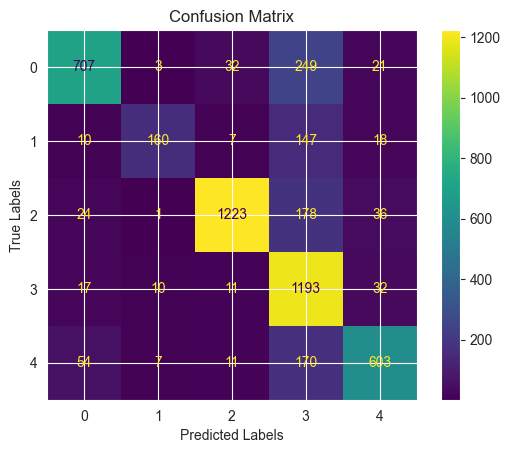

In [56]:
param_grid=[
    {'kernel': ['linear','poly', 'rbf']}
]

svm = SVC(C=0.5)
y_pred = pipline(tr_data, ts_data, svm, param_grid)

In [57]:
ts_data['Y'] = y_pred
final_data = ts_data.copy()

In [58]:
final_data

,Sentence,Emotion,Y
0,صعب روزید#روز ، بوالعجب کاشت#کار ، پریشان عالمی,None,OTHER
1,بسیار نرم و لطیف بوده و کیفیت بالایی داره .,None,HAPPY
2,اصلا رنگ با چیزی که تو عکس بود#است خیلی فرق داشت,None,ANGRY
3,خیلی زیبا و ب اندازه و با دقت طراحی‌شده,None,HAPPY
4,سبزی‌پلو با ماهی مال عید نوروزه ، امشب سوشی خو...,None,OTHER
...,...,...,...
543,سرخط خبرهای ۶ عصر ، پنجشنبه ۲۹ جدی ۱۴۰۱,None,OTHER
544,بوی عالی ماندگاری خوب خیلی خو امدش مرسی دیج,None,HAPPY
545,گاز که داشت#دار اینترنت هم روش ? #وطن,None,ANGRY
546,من چندتاشو برا مغازه گرفت#گیر باطریاشون کلا خر...,None,HAPPY


In [59]:
final_data.drop(['Emotion'], axis=1)
final_data.to_csv('test.csv', index=False)